In [1]:
from datasets import load_dataset
from fim.utils.interpolator import KernelInterpolator
from fim.models.hawkes.thinning import EventSampler
from fim.models.hawkes import FIMHawkes
import torch
from matplotlib import pyplot as plt
from functools import partial

In [2]:
data = load_dataset("FIM4Science/hawkes-synthetic-short-scale-single-process", "train_process_8")
data.set_format(type='torch')

In [3]:
marks = data['train'][0]['target_kernel_evaluations'].size(0)

In [4]:
!nvidia-smi


Mon Apr  7 15:16:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:4E:00.0 Off |                    0 |
| N/A   34C    P0             62W /  400W |       1MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# Intensity calculation

$ \hat{\lambda}_k(t) = \text{ReLU}\left( \hat{\lambda}^0_k + \sum_{i: t_{ki} < t} \hat{K}_k(t - t_{ki})\right)$  

In [5]:
split="test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda"

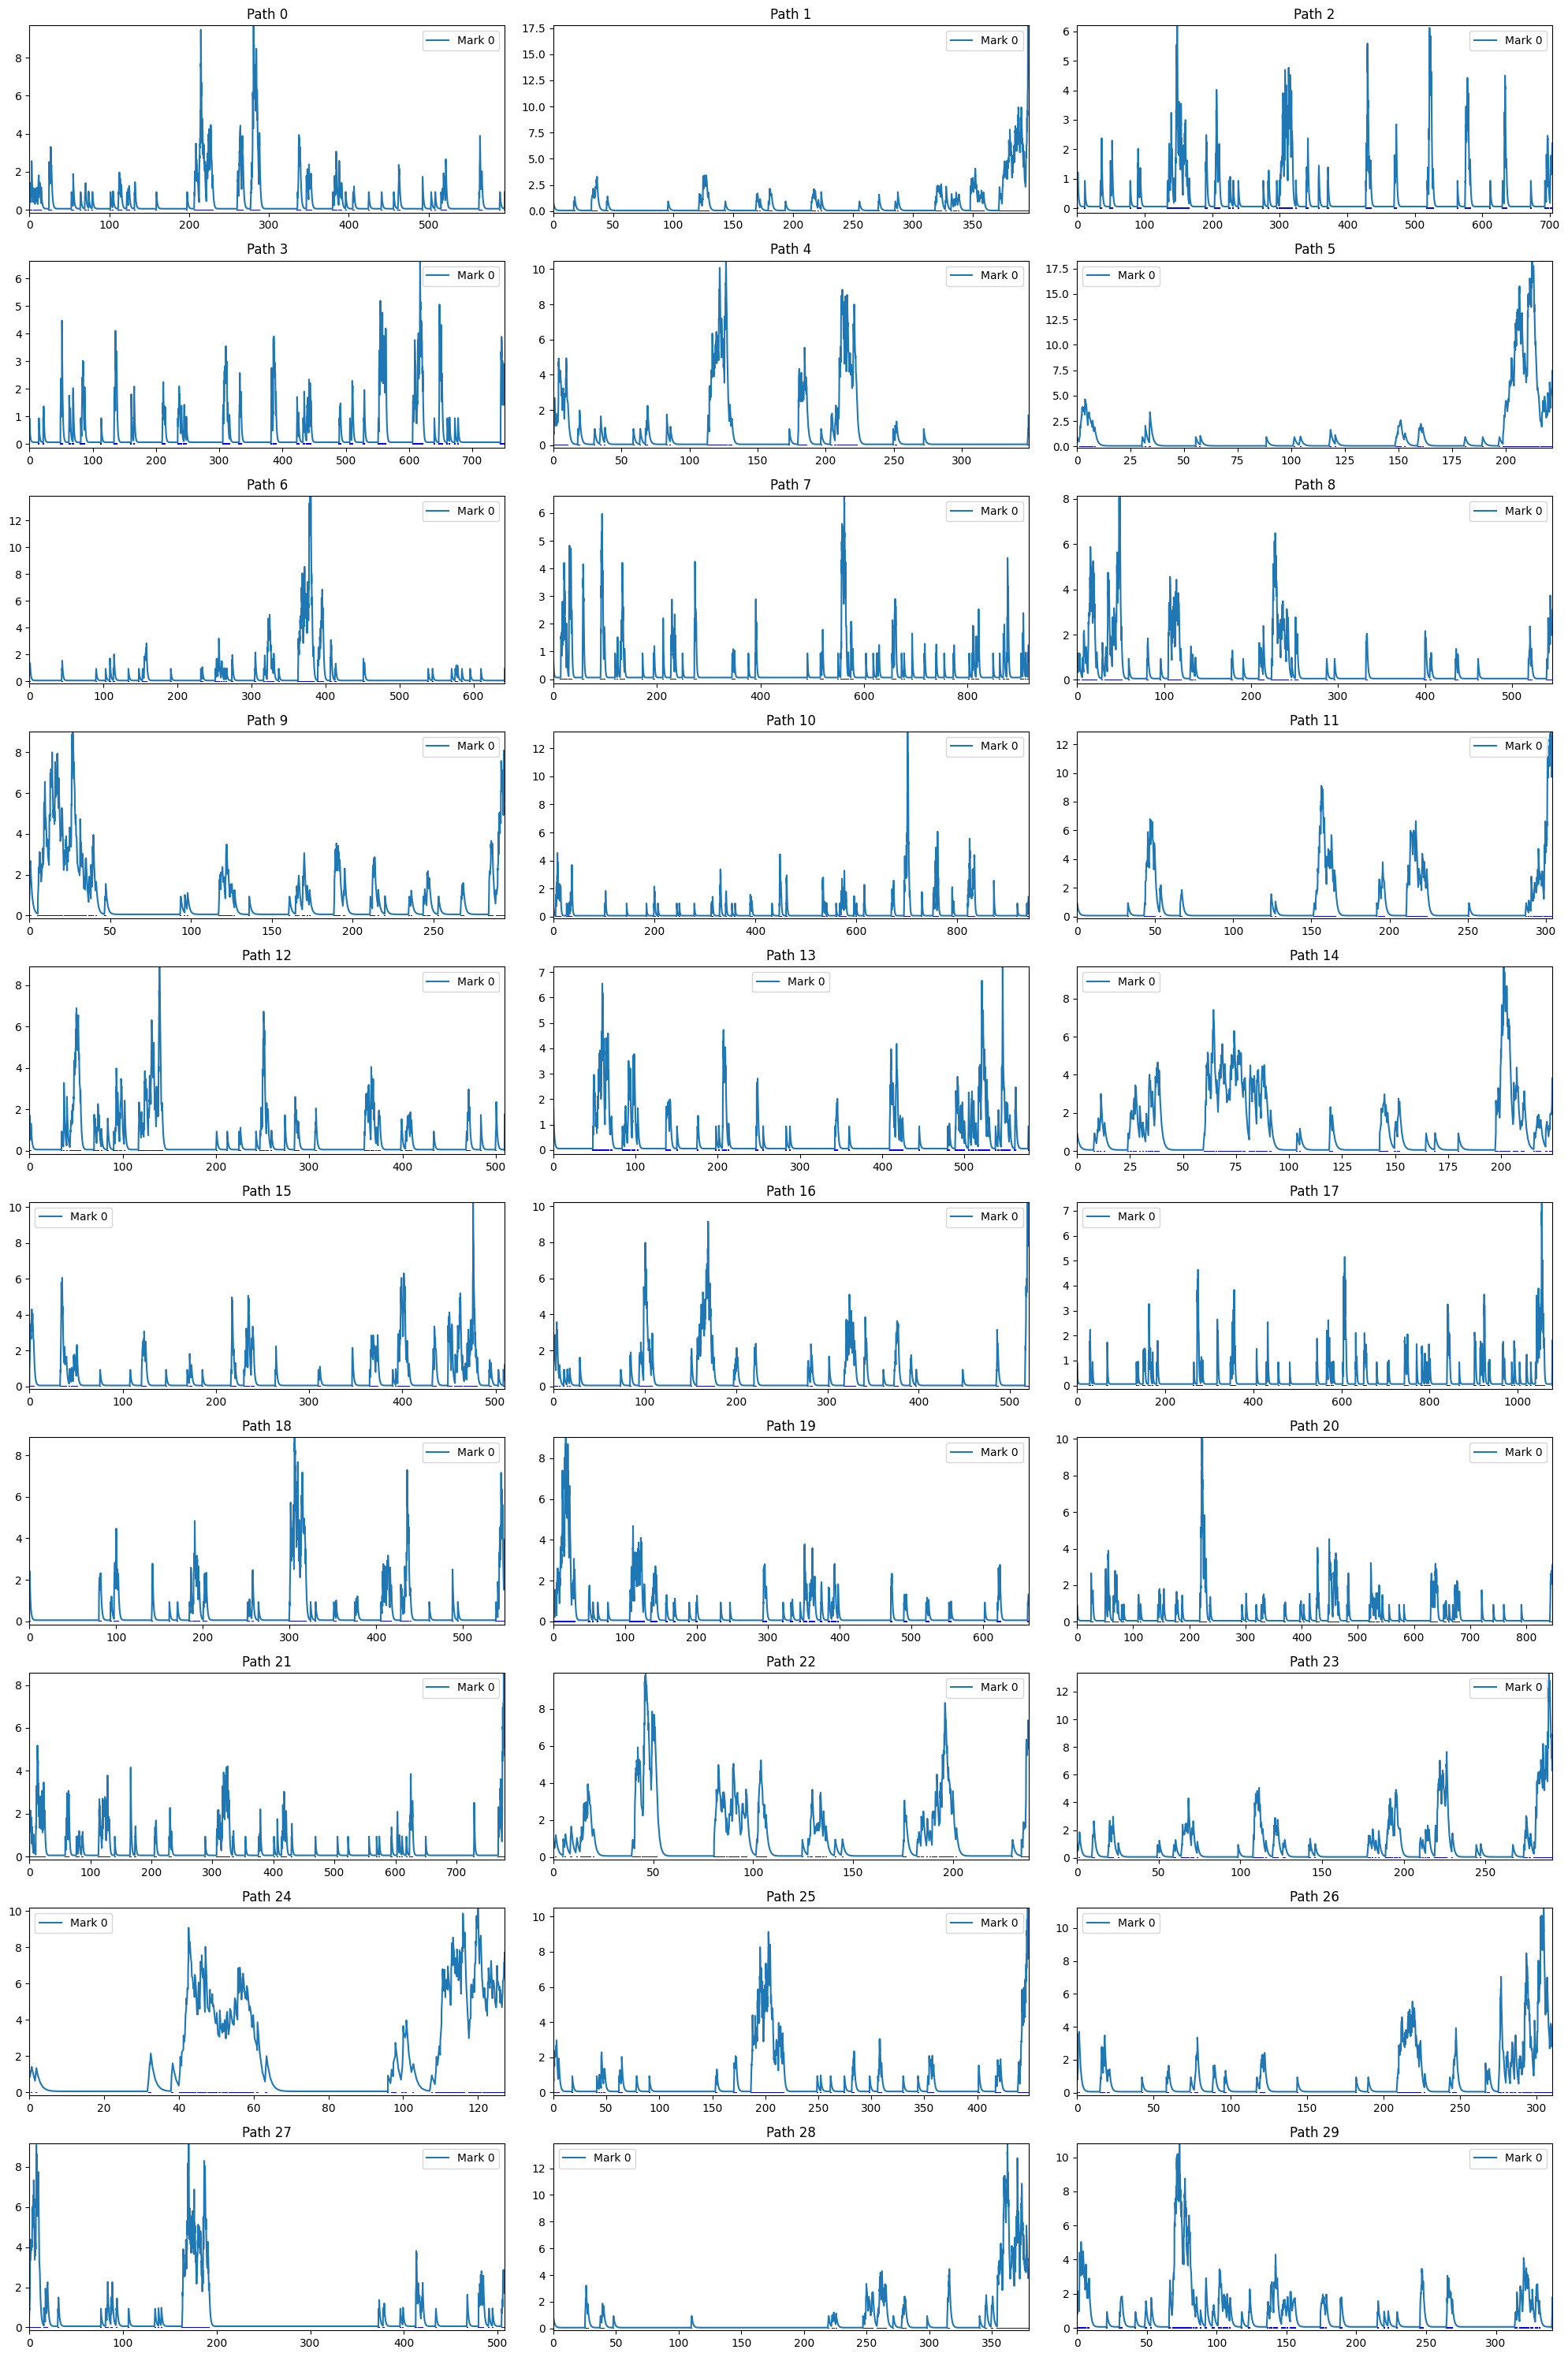

In [6]:
fig, axes = plt.subplots(10, 3, figsize=(20, 30))
axes = axes.flatten()

for i in range(30):
    time_intensities = data[split][i]['target_intensity_times']
    intensities = data[split][i]['target_intensities']

    for mark in range(marks):
        # Plot intensities
        # Plot events
        event_times = data[split][i]['time_since_start']
        event_types = data[split][i]['type_event']
        event_times_by_type = [event_times[event_types == mark].tolist() for mark in range(3)]
        axes[i].eventplot(event_times_by_type, colors=['blue', 'orange', 'green'], linelengths=0.05)
        axes[i].plot(time_intensities, intensities[mark], label=f'Mark {mark}')

    # axes[i].set_xlim(0, 500)

    axes[i].set_xlim(0, time_intensities.max())
    axes[i].set_ylim(-0.15, intensities.max())

    axes[i].set_title(f'Path {i}')
    axes[i].legend()

plt.tight_layout()
plt.show()


Query points are out of bounds of the grid points. The kernel values for these points will be set to 0.


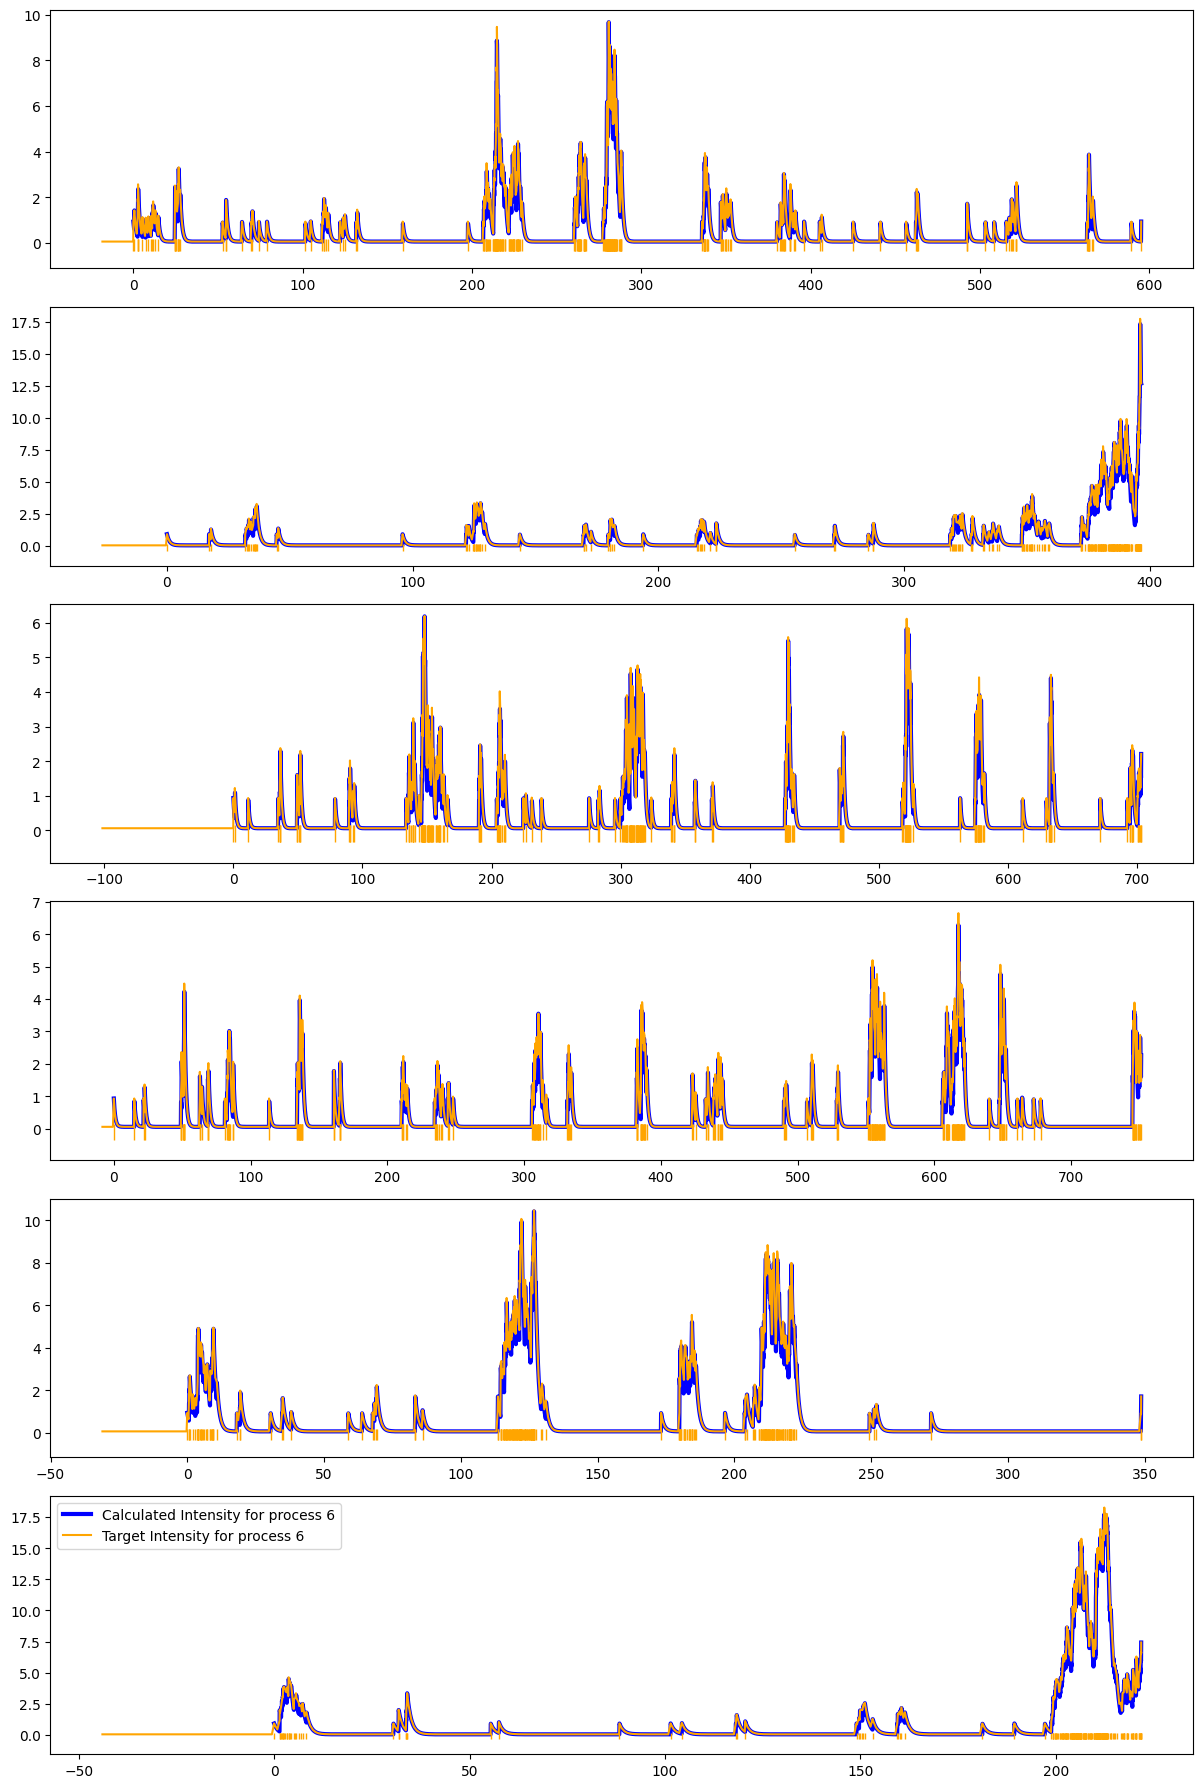

In [9]:
kernel_interpolator = KernelInterpolator(data[split][0]['target_kernel_grids'].to(device), data[split][0]['target_kernel_evaluations'].to(device), mode="interpolate", out_of_bounds_value=0)
intensity_fn = partial(FIMHawkes.intentsity, kernel=kernel_interpolator, base_intensity=data[split][0]["target_base_intensities"].to(device))

n_processes = 6
use_target_times = False
M = data[split][0]['target_intensities'].shape[0]
if use_target_times:
   intensity = []
   for i in range(n_processes):
      t_values = data[split][i]['target_intensity_times']
      intensity.append(intensity_fn(t_values.unsqueeze(0).unsqueeze(-1).to(device), data[split][i]['time_since_start'].unsqueeze(0).to(device)))
else:
   t_values = torch.stack([torch.linspace(0, data[split][i]['target_intensity_times'].max(), 5000, device=device) for i in range(n_processes)])
   intensity = intensity_fn(t_values.unsqueeze(-1), data[split][:n_processes]['time_since_start'].to(device))

fig, ax = plt.subplots(n_processes, 1, figsize=(12, 18))
axes = ax.flatten()
for i in range(n_processes):
   for k in range(M):
      if use_target_times:
         axes[i].plot(data[split][i]['target_intensity_times'].cpu().squeeze(), intensity[i][:, :, :, k].cpu().squeeze(), label=f'Calculated Intensity for process {i+1}', color="blue", linewidth=3)
      else:
         axes[i].plot(t_values[i].cpu().squeeze(), intensity[i, :, :, k].cpu().squeeze(), label=f'Calculated Intensity for process {i+1}', color="blue", linewidth=3)
      axes[i].plot(data[split][i]['target_intensity_times'].cpu().squeeze(), data[split][i]['target_intensities'][k].cpu().squeeze(), label=f'Target Intensity for process {i+1}', color="orange")
      time_since_start = data[split][i]['time_since_start'][data[split][i]['type_event'] == k]
      axes[i].eventplot(time_since_start.cpu().squeeze(), color='orange', linelengths=0.5, linewidths=1., lineoffsets=-0.1)
      # axes[i].set_xlim(0, 50)
plt.tight_layout()
plt.legend()
plt.show()

In [9]:
kernel_interpolator = KernelInterpolator(data[split][0]['target_kernel_grids'].to(device), data[split][0]['target_kernel_evaluations'].to(device), mode="interpolate", out_of_bounds_value=0)
intensity_fn = partial(FIMHawkes.intentsity, kernel=kernel_interpolator, base_intensity=data[split][0]["target_base_intensities"].to(device))

sampler = EventSampler(num_sample=2, device=device, num_exp=500)

instances = data[split][27:28]
time_since_start = instances['time_since_start'].squeeze(-1).to(device)

accepted_dtimes, weights = sampler.draw_next_time_one_step(time_since_start, instances['time_since_last_event'].squeeze(-1).to(device), instances['type_event'].squeeze(-1).to(device), intensity_fn, False)

# We should condition on each accepted time to sample event mark, but not conditioned on the expected event time.
# 1. Use all accepted_dtimes to get intensity.
# [batch_size, seq_len, num_sample, num_marks]
intensities_at_times = intensity_fn(accepted_dtimes, time_since_start)

# 2. Normalize the intensity over last dim and then compute the weighted sum over the `num_sample` dimension.
# Each of the last dimension is a categorical distribution over all marks.
# [batch_size, seq_len, num_sample, num_marks]
intensities_normalized = intensities_at_times / intensities_at_times.sum(dim=-1, keepdim=True)

# 3. Compute weighted sum of distributions and then take argmax.
# [batch_size, seq_len, num_marks]
intensities_weighted = torch.einsum('...s,...sm->...m', weights, intensities_normalized)

# [batch_size, seq_len]
types_pred = torch.argmax(intensities_weighted, dim=-1)

# [batch_size, seq_len]
dtimes_pred = torch.sum(accepted_dtimes * weights, dim=-1)  # compute the expected next event time


Query points are out of bounds of the grid points. The kernel values for these points will be set to 0.
Query points are out of bounds of the grid points. The kernel values for these points will be set to 0.
Query points are out of bounds of the grid points. The kernel values for these points will be set to 0.


In [16]:
print(accepted_dtimes.shape)
print(dtimes_pred.shape)
print(intensities_at_times.shape)



torch.Size([1, 250, 2])
torch.Size([1, 250])
torch.Size([1, 250, 2, 1])


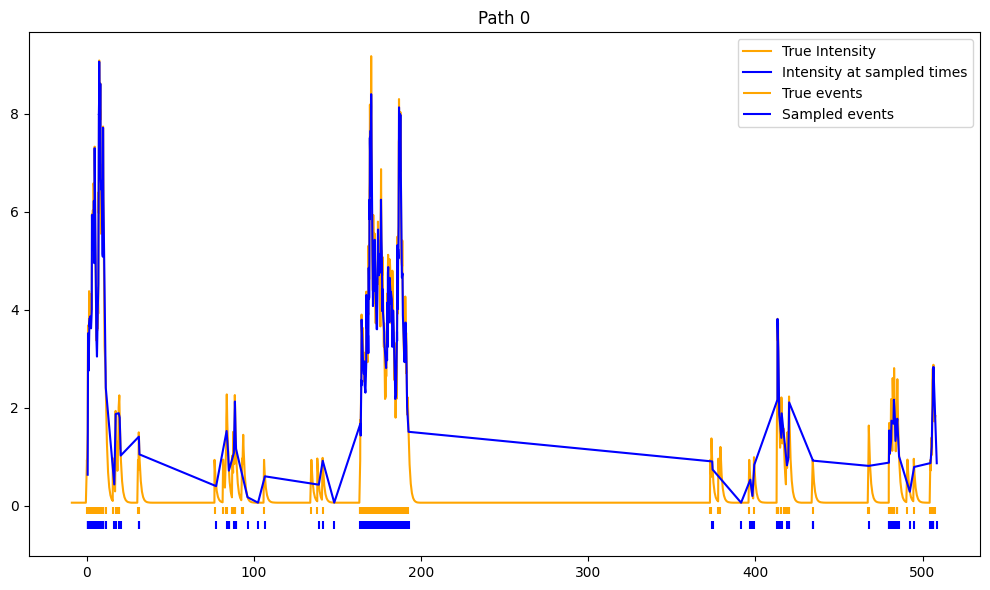

In [10]:

c = ['blue', 'orange', 'green']
path_id = 0
plt.figure(figsize=(10, 6))
# Sort accepted times and corresponding intensities
sorted_indices = torch.argsort(accepted_dtimes[path_id].squeeze())
sorted_accepted_dtimes = accepted_dtimes[path_id].squeeze()[sorted_indices]
sorted_intensities_at_times = intensities_at_times[path_id].squeeze()[sorted_indices]

plt.plot(instances['target_intensity_times'].squeeze(), instances['target_intensities'].squeeze(), label='True Intensity', color="orange")
plt.plot(sorted_accepted_dtimes.cpu(), sorted_intensities_at_times.cpu(), label='Intensity at sampled times', color="blue")
plt.eventplot(instances['time_since_start'].squeeze(), linelengths=0.15, colors='orange', lineoffsets=-0.1, label='True events')
plt.eventplot(dtimes_pred[path_id].cpu(), linelengths=0.15, colors='blue', lineoffsets=-0.4, label='Sampled events')

plt.title(f'Path {path_id}')
plt.legend()
# plt.xlim(0, 250)
# plt.ylim(-.5, 5)
# plt.xlim(-1, 5)
plt.tight_layout()
plt.show()

Query points are out of bounds of the grid points. The kernel values for these points will be set to 0.


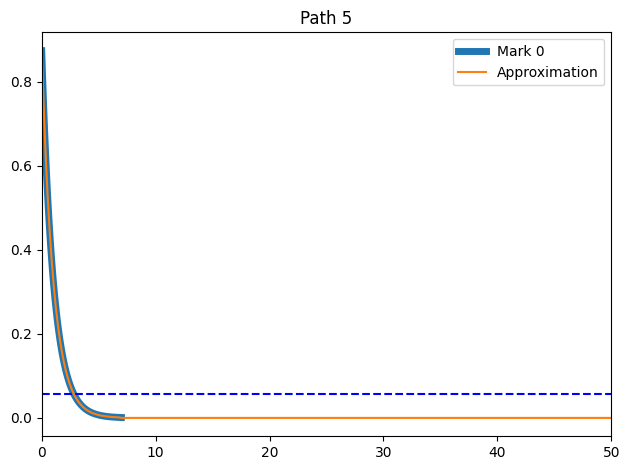

In [11]:

time_intensities = data['train'][0]['target_kernel_grids']
intensities = data['train'][0]['target_kernel_evaluations']
interpolator = KernelInterpolator(data[split][0]['target_kernel_grids'].to(device), data[split][0]['target_kernel_evaluations'].to(device), mode="interpolate", out_of_bounds_value=0)
sample_times = torch.linspace(data[split][0]['target_kernel_grids'].min(), data[split][0]['target_kernel_grids'].max()*50, 2000, device=device).unsqueeze(0)
approx = interpolator(sample_times.unsqueeze(0))
c = ['blue', 'orange', 'green']
for mark in range(marks):
    plt.plot(time_intensities[mark].cpu(), intensities[mark].cpu(), label=f'Mark {mark}', linewidth=5)
    plt.plot(sample_times.squeeze().cpu(), approx.squeeze().cpu(), label=f'Approximation')
    plt.axhline(data['train'][0]['target_base_intensities'][mark], color=c[mark], linestyle='--')

plt.title(f'Path {i}')
plt.legend()
plt.xlim(0, 50)

plt.tight_layout()
plt.show()